Moisés Campillo Yniesta

Antonio García Alcón

En esta práctica intentaremos predecir el precio de los vehiculos según los datos recogidos en el dataset autos.csv, disponible en:

https://data.world/data-society/used-cars-data

#Imports

In [ ]:
#!pip freeze > requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score
from pandas import read_csv
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

#Descargar y Cargar el Dataset

Este proyecto se ha llevado a cabo en Google Colab por lo que recomendamos que se ejecute en ese entorno.

Con la siguientes celdas nos descargamos el dataset de una carpeta de Mega que hemos creado para facilitar la descarga.

Por si acaso, también se puede descargar del siguiente link y subirlo como archivo al mismo Colab :

https://mega.nz/file/EdhUxZTK#ZvgSSkWD-fL9M2xNjQiriD0RAqTGqdPVwBYS039dC8E



In [ ]:
!pip install mega.py

In [ ]:
from mega import Mega

mega = Mega()
m = mega.login()

m.download_url('https://mega.nz/file/EdhUxZTK#ZvgSSkWD-fL9M2xNjQiriD0RAqTGqdPVwBYS039dC8E')

PosixPath('autos.csv')

La siguiente celda ejecuta el comando para cargar y visualizar el dataset

In [ ]:
data = read_csv("autos.csv",header=0,delimiter=',',encoding='latin-1')
data.describe(include="all")

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
count,371528,371528,371528,371528,3.715280e+05,371528,333659,371528.000000,351319,371528.000000,351044,371528.000000,371528.000000,338142,371528,299468,371528,371528.0,371528.00000,371528
unique,280500,233531,2,2,NaN,2,8,NaN,2,NaN,251,NaN,NaN,7,40,2,114,NaN,NaN,182806
top,2016-03-24 14:49:47,Ford_Fiesta,privat,Angebot,NaN,test,limousine,NaN,manuell,NaN,golf,NaN,NaN,benzin,volkswagen,nein,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,657,371525,371516,NaN,192585,95894,NaN,274214,NaN,30070,NaN,NaN,223857,79640,263182,14450,NaN,NaN,17
mean,NaN,NaN,NaN,NaN,1.729514e+04,NaN,NaN,2004.577997,NaN,115.549477,NaN,125618.688228,5.734445,NaN,NaN,NaN,NaN,0.0,50820.66764,NaN
std,NaN,NaN,NaN,NaN,3.587954e+06,NaN,NaN,92.866598,NaN,192.139578,NaN,40112.337051,3.712412,NaN,NaN,NaN,NaN,0.0,25799.08247,NaN
min,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.00000,NaN
25%,NaN,NaN,NaN,NaN,1.150000e+03,NaN,NaN,1999.000000,NaN,70.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30459.00000,NaN
50%,NaN,NaN,NaN,NaN,2.950000e+03,NaN,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49610.00000,NaN
75%,NaN,NaN,NaN,NaN,7.200000e+03,NaN,NaN,2008.000000,NaN,150.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71546.00000,NaN


#Preprocessing

Primero nos desharemos de las columnas que no son útiles para predecir el precio de los coches.

In [ ]:
data.drop(columns=['dateCrawled', 'dateCreated' , 'nrOfPictures', 'postalCode','lastSeen', 'monthOfRegistration' ], inplace=True)
data.describe(include="all")

,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
count,371528,371528,371528,3.715280e+05,371528,333659,371528.000000,351319,371528.000000,351044,371528.000000,338142,371528,299468
unique,233531,2,2,NaN,2,8,NaN,2,NaN,251,NaN,7,40,2
top,Ford_Fiesta,privat,Angebot,NaN,test,limousine,NaN,manuell,NaN,golf,NaN,benzin,volkswagen,nein
freq,657,371525,371516,NaN,192585,95894,NaN,274214,NaN,30070,NaN,223857,79640,263182
mean,NaN,NaN,NaN,1.729514e+04,NaN,NaN,2004.577997,NaN,115.549477,NaN,125618.688228,NaN,NaN,NaN
std,NaN,NaN,NaN,3.587954e+06,NaN,NaN,92.866598,NaN,192.139578,NaN,40112.337051,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000e+00,NaN,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,1.150000e+03,NaN,NaN,1999.000000,NaN,70.000000,NaN,125000.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,2.950000e+03,NaN,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,7.200000e+03,NaN,NaN,2008.000000,NaN,150.000000,NaN,150000.000000,NaN,NaN,NaN


Nos desharemos también de *seller* y *offerType* ya que, como podemos ver en el describe del dataset, prácticamente todos los datos se corresponden a un elemento de los 2 posibles en su columna y, por lo tanto, a la hora de entrenar un modelo tendrían muy poca importancia.

In [ ]:
data.drop(columns=['seller', 'offerType' ], inplace=True)
data.describe(include="all")

,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
count,371528,3.715280e+05,371528,333659,371528.000000,351319,371528.000000,351044,371528.000000,338142,371528,299468
unique,233531,NaN,2,8,NaN,2,NaN,251,NaN,7,40,2
top,Ford_Fiesta,NaN,test,limousine,NaN,manuell,NaN,golf,NaN,benzin,volkswagen,nein
freq,657,NaN,192585,95894,NaN,274214,NaN,30070,NaN,223857,79640,263182
mean,NaN,1.729514e+04,NaN,NaN,2004.577997,NaN,115.549477,NaN,125618.688228,NaN,NaN,NaN
std,NaN,3.587954e+06,NaN,NaN,92.866598,NaN,192.139578,NaN,40112.337051,NaN,NaN,NaN
min,NaN,0.000000e+00,NaN,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,NaN,NaN,NaN
25%,NaN,1.150000e+03,NaN,NaN,1999.000000,NaN,70.000000,NaN,125000.000000,NaN,NaN,NaN
50%,NaN,2.950000e+03,NaN,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,NaN,NaN,NaN
75%,NaN,7.200000e+03,NaN,NaN,2008.000000,NaN,150.000000,NaN,150000.000000,NaN,NaN,NaN


También, tanto *model* como *name* son columnas un tanto redundantes ya que tenemos *brand* y *vehicleType* que nos da una información suficiente del vehículo. Además, al ser categóricas con un número de categorías tan alto nos haría incluir muchas columnas lo que aumentaría el coste computacional de la predicción.

In [ ]:
data.drop(columns=['model', 'name' ], inplace=True)
data.describe(include="all")

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,fuelType,brand,notRepairedDamage
count,3.715280e+05,371528,333659,371528.000000,351319,371528.000000,371528.000000,338142,371528,299468
unique,NaN,2,8,NaN,2,NaN,NaN,7,40,2
top,NaN,test,limousine,NaN,manuell,NaN,NaN,benzin,volkswagen,nein
freq,NaN,192585,95894,NaN,274214,NaN,NaN,223857,79640,263182
mean,1.729514e+04,NaN,NaN,2004.577997,NaN,115.549477,125618.688228,NaN,NaN,NaN
std,3.587954e+06,NaN,NaN,92.866598,NaN,192.139578,40112.337051,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,1000.000000,NaN,0.000000,5000.000000,NaN,NaN,NaN
25%,1.150000e+03,NaN,NaN,1999.000000,NaN,70.000000,125000.000000,NaN,NaN,NaN
50%,2.950000e+03,NaN,NaN,2003.000000,NaN,105.000000,150000.000000,NaN,NaN,NaN
75%,7.200000e+03,NaN,NaN,2008.000000,NaN,150.000000,150000.000000,NaN,NaN,NaN


A continuación trataremos los **missings**:

Según la descripción del dataset, la columna *notRepairedDamage* representa "si el coche tiene daños que no han sido reparados todavía", por tanto interpretaremos los missings de dicha columna como que el coche no ha sufrido daños y lo codificaremos como "nein"

In [ ]:
data.notRepairedDamage = data.notRepairedDamage.fillna("nein")
data.describe(include="all")

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,fuelType,brand,notRepairedDamage
count,3.715280e+05,371528,333659,371528.000000,351319,371528.000000,371528.000000,338142,371528,371528
unique,NaN,2,8,NaN,2,NaN,NaN,7,40,2
top,NaN,test,limousine,NaN,manuell,NaN,NaN,benzin,volkswagen,nein
freq,NaN,192585,95894,NaN,274214,NaN,NaN,223857,79640,335242
mean,1.729514e+04,NaN,NaN,2004.577997,NaN,115.549477,125618.688228,NaN,NaN,NaN
std,3.587954e+06,NaN,NaN,92.866598,NaN,192.139578,40112.337051,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,1000.000000,NaN,0.000000,5000.000000,NaN,NaN,NaN
25%,1.150000e+03,NaN,NaN,1999.000000,NaN,70.000000,125000.000000,NaN,NaN,NaN
50%,2.950000e+03,NaN,NaN,2003.000000,NaN,105.000000,150000.000000,NaN,NaN,NaN
75%,7.200000e+03,NaN,NaN,2008.000000,NaN,150.000000,150000.000000,NaN,NaN,NaN


Como disponemos de una cantidad muy grande de datos y dada la dificultad de imputar correctamente el tipo de vehículo, el tipo de combustible usado y el tipo de marchas (manual o automatico), eliminaremos las filas donde haya missings.

In [ ]:
data = data.dropna(axis=0)
data.describe(include="all")

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,fuelType,brand,notRepairedDamage
count,3.099000e+05,309900,309900,309900.000000,309900,309900.000000,309900.000000,309900,309900,309900
unique,NaN,2,8,NaN,2,NaN,NaN,7,40,2
top,NaN,test,limousine,NaN,manuell,NaN,NaN,benzin,volkswagen,nein
freq,NaN,160760,89859,NaN,239219,NaN,NaN,204146,64633,280595
mean,1.587303e+04,NaN,NaN,2002.788277,NaN,123.580742,125222.345918,NaN,NaN,NaN
std,3.883970e+06,NaN,NaN,6.786477,NaN,178.786494,39535.881046,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,1910.000000,NaN,0.000000,5000.000000,NaN,NaN,NaN
25%,1.350000e+03,NaN,NaN,1999.000000,NaN,75.000000,100000.000000,NaN,NaN,NaN
50%,3.490000e+03,NaN,NaN,2003.000000,NaN,114.000000,150000.000000,NaN,NaN,NaN
75%,7.999000e+03,NaN,NaN,2007.000000,NaN,150.000000,150000.000000,NaN,NaN,NaN


A continuacion identificaremos los posibles **valores erróneos** de nuestros datos:

Haciendo una búsqueda por internet, sabemos que, actualmente, el coche con menor PS es de 79PS y el máximo es de 916PS. Sabiendo esto, podemos asegurar que los valores superiores e inferiores a estas cotas son erroneos y nos desharemos de ellos.

In [ ]:
data.where( (data.powerPS < 916) & (data.powerPS > 79) , inplace = True)
data.describe()

,price,yearOfRegistration,powerPS,kilometer
count,2.239120e+05,223912.000000,223912.000000,223912.000000
mean,1.989140e+04,2003.744225,147.551659,125430.861231
std,4.559188e+06,6.359516,59.022861,39583.123713
min,0.000000e+00,1910.000000,80.000000,5000.000000
25%,2.090000e+03,2000.000000,105.000000,100000.000000
50%,4.900000e+03,2004.000000,136.000000,150000.000000
75%,9.999000e+03,2008.000000,170.000000,150000.000000
max,2.147484e+09,2018.000000,909.000000,150000.000000


Como no sabemos cual es el precio mínimo razonable a la hora de vender un coche solo podemos descartar aquellos con precio igual a 0. Trataremos los demás valores pequeños como correctos y mas adelante veremos si se tratan de outliers.

In [ ]:
data.where( (data.price > 0), inplace = True)
data.describe()

,price,yearOfRegistration,powerPS,kilometer
count,2.206450e+05,220645.000000,220645.000000,220645.000000
mean,2.018592e+04,2003.806993,147.650552,125302.408847
std,4.592816e+06,6.333769,59.120645,39598.849868
min,1.000000e+00,1910.000000,80.000000,5000.000000
25%,2.200000e+03,2000.000000,105.000000,100000.000000
50%,4.999000e+03,2004.000000,136.000000,150000.000000
75%,1.000000e+04,2008.000000,170.000000,150000.000000
max,2.147484e+09,2018.000000,909.000000,150000.000000


In [ ]:
data = data.dropna(axis=0)
data.describe(include="all")

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,fuelType,brand,notRepairedDamage
count,2.206450e+05,220645,220645,220645.000000,220645,220645.000000,220645.000000,220645,220645,220645
unique,NaN,2,8,NaN,2,NaN,NaN,7,39,2
top,NaN,test,limousine,NaN,manuell,NaN,NaN,benzin,volkswagen,nein
freq,NaN,114135,74558,NaN,159352,NaN,NaN,128055,40343,202405
mean,2.018592e+04,NaN,NaN,2003.806993,NaN,147.650552,125302.408847,NaN,NaN,NaN
std,4.592816e+06,NaN,NaN,6.333769,NaN,59.120645,39598.849868,NaN,NaN,NaN
min,1.000000e+00,NaN,NaN,1910.000000,NaN,80.000000,5000.000000,NaN,NaN,NaN
25%,2.200000e+03,NaN,NaN,2000.000000,NaN,105.000000,100000.000000,NaN,NaN,NaN
50%,4.999000e+03,NaN,NaN,2004.000000,NaN,136.000000,150000.000000,NaN,NaN,NaN
75%,1.000000e+04,NaN,NaN,2008.000000,NaN,170.000000,150000.000000,NaN,NaN,NaN


Ahora trataremos los **outliers** de nuestro dataset:

Observamos los boxplot de precio y de precio en función de la marca:

count    2.206450e+05
mean     2.018592e+04
std      4.592816e+06
min      1.000000e+00
25%      2.200000e+03
50%      4.999000e+03
75%      1.000000e+04
max      2.147484e+09
Name: price, dtype: float64

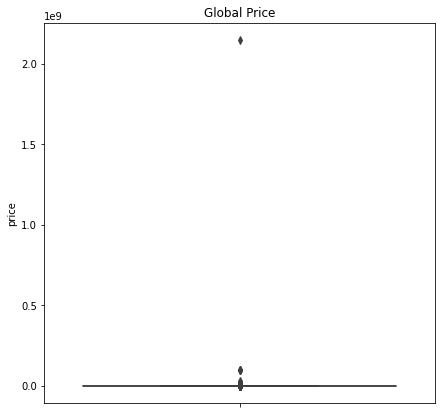

In [ ]:
plt.rcParams['figure.figsize']=(7,7)
sn.boxplot(y="price", data=data).set_title('Global Price');
data.price.describe()

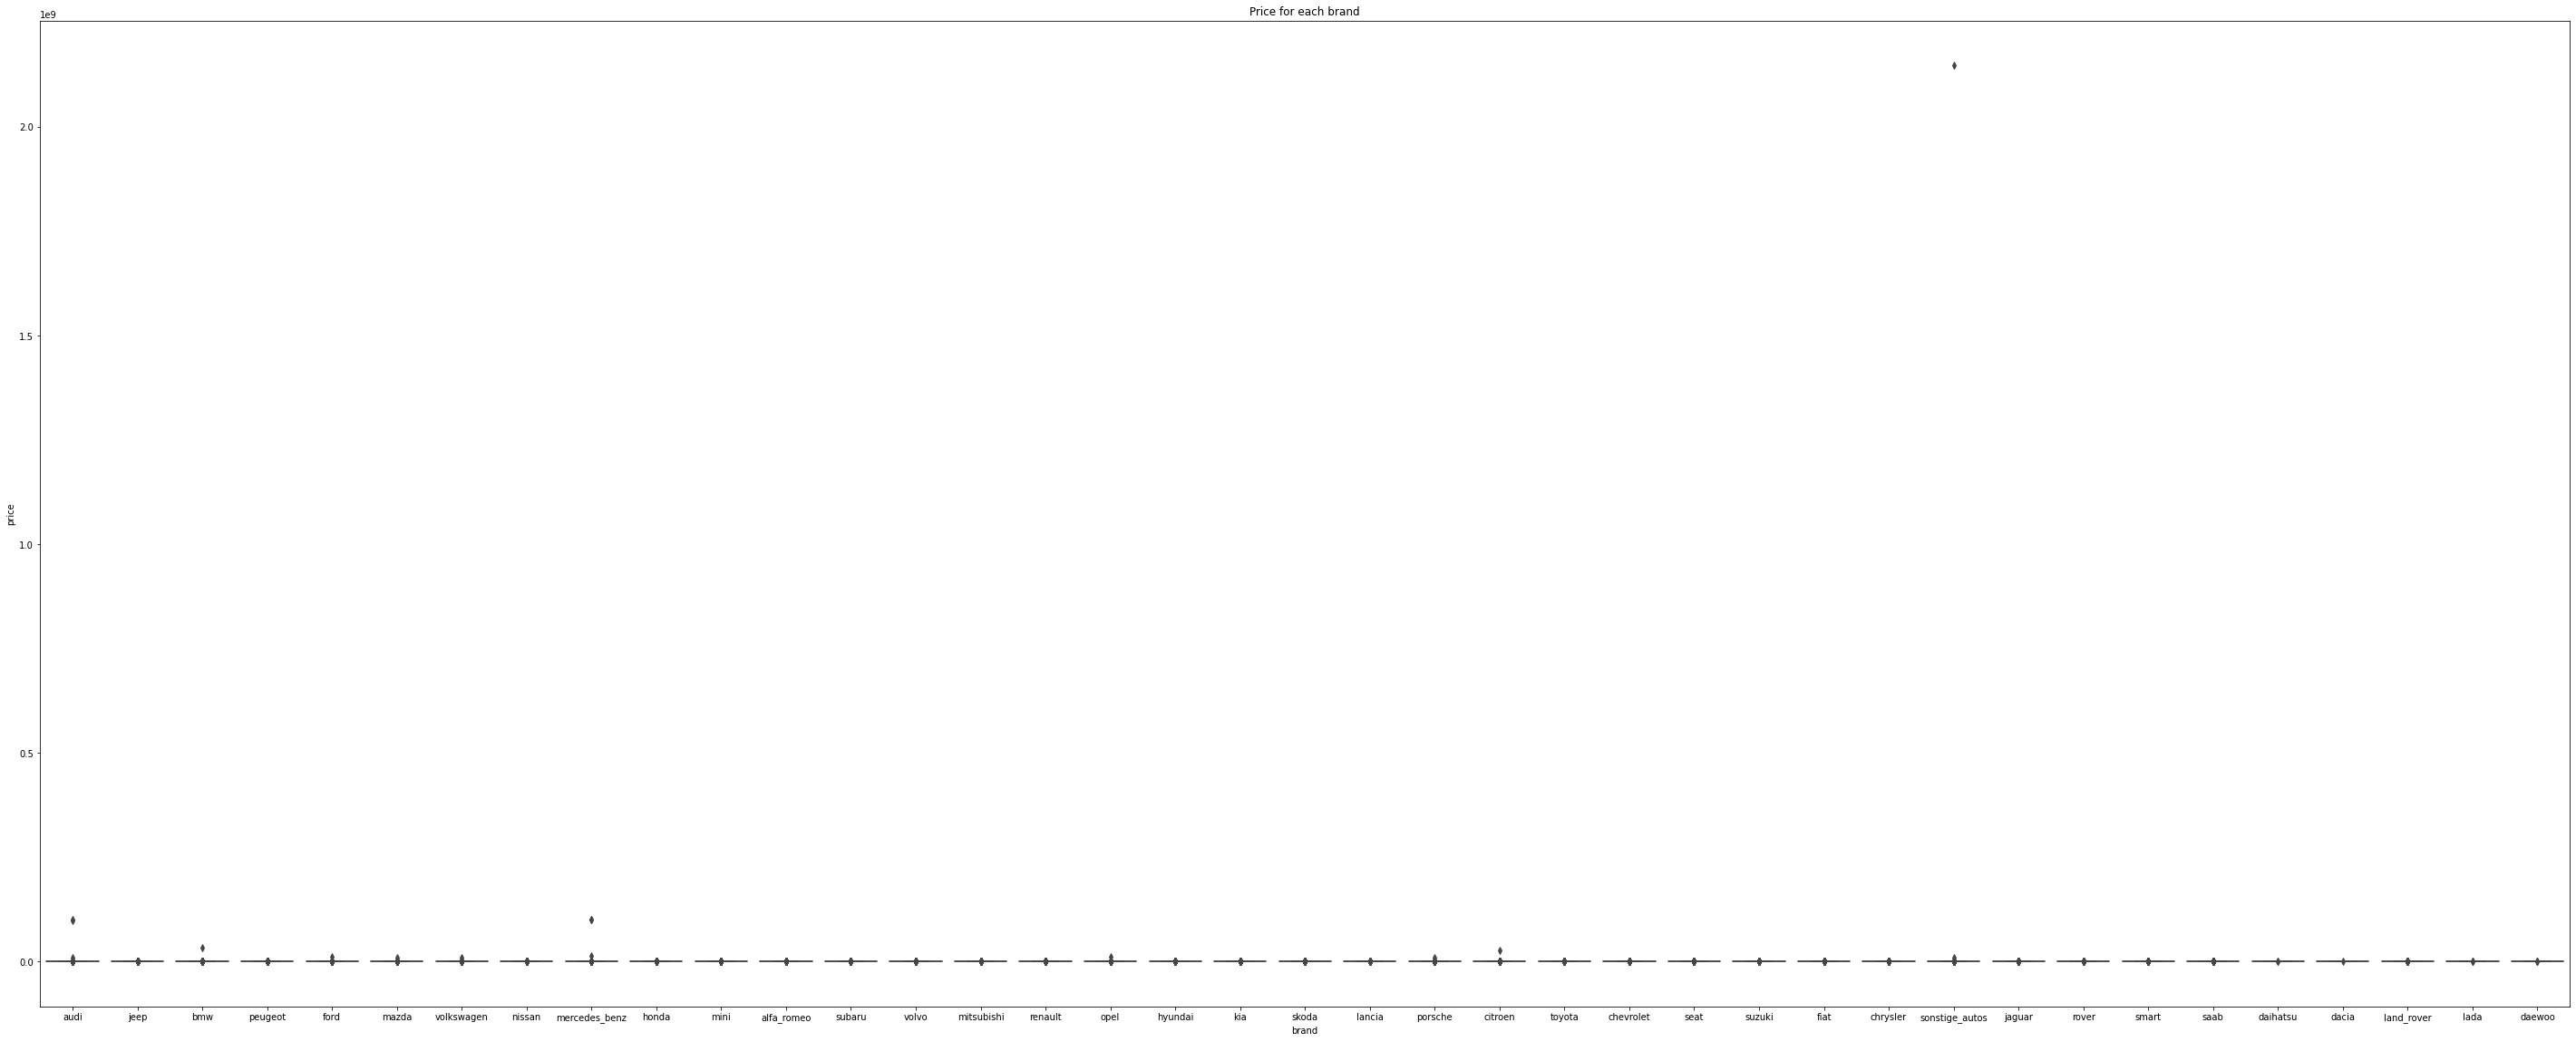

In [ ]:
plt.rcParams['figure.figsize']=(50,20)
sn.boxplot(x='brand', y="price", data=data).set_title('Price for each brand');

Como se puede ver, tenemos claros outliers de los que nos desharemos

In [ ]:
data.where( (data.price < 1000000), inplace = True)
data = data.dropna()

count    220626.000000
mean       7950.765685
std       12179.770851
min           1.000000
25%        2200.000000
50%        4999.000000
75%       10000.000000
max      999999.000000
Name: price, dtype: float64

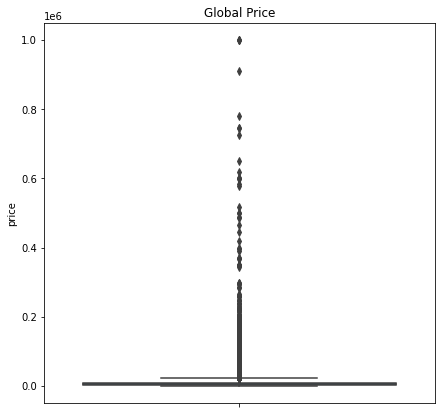

In [ ]:
plt.rcParams['figure.figsize']=(7,7)
sn.boxplot(y="price", data=data).set_title('Global Price');
data.price.describe()

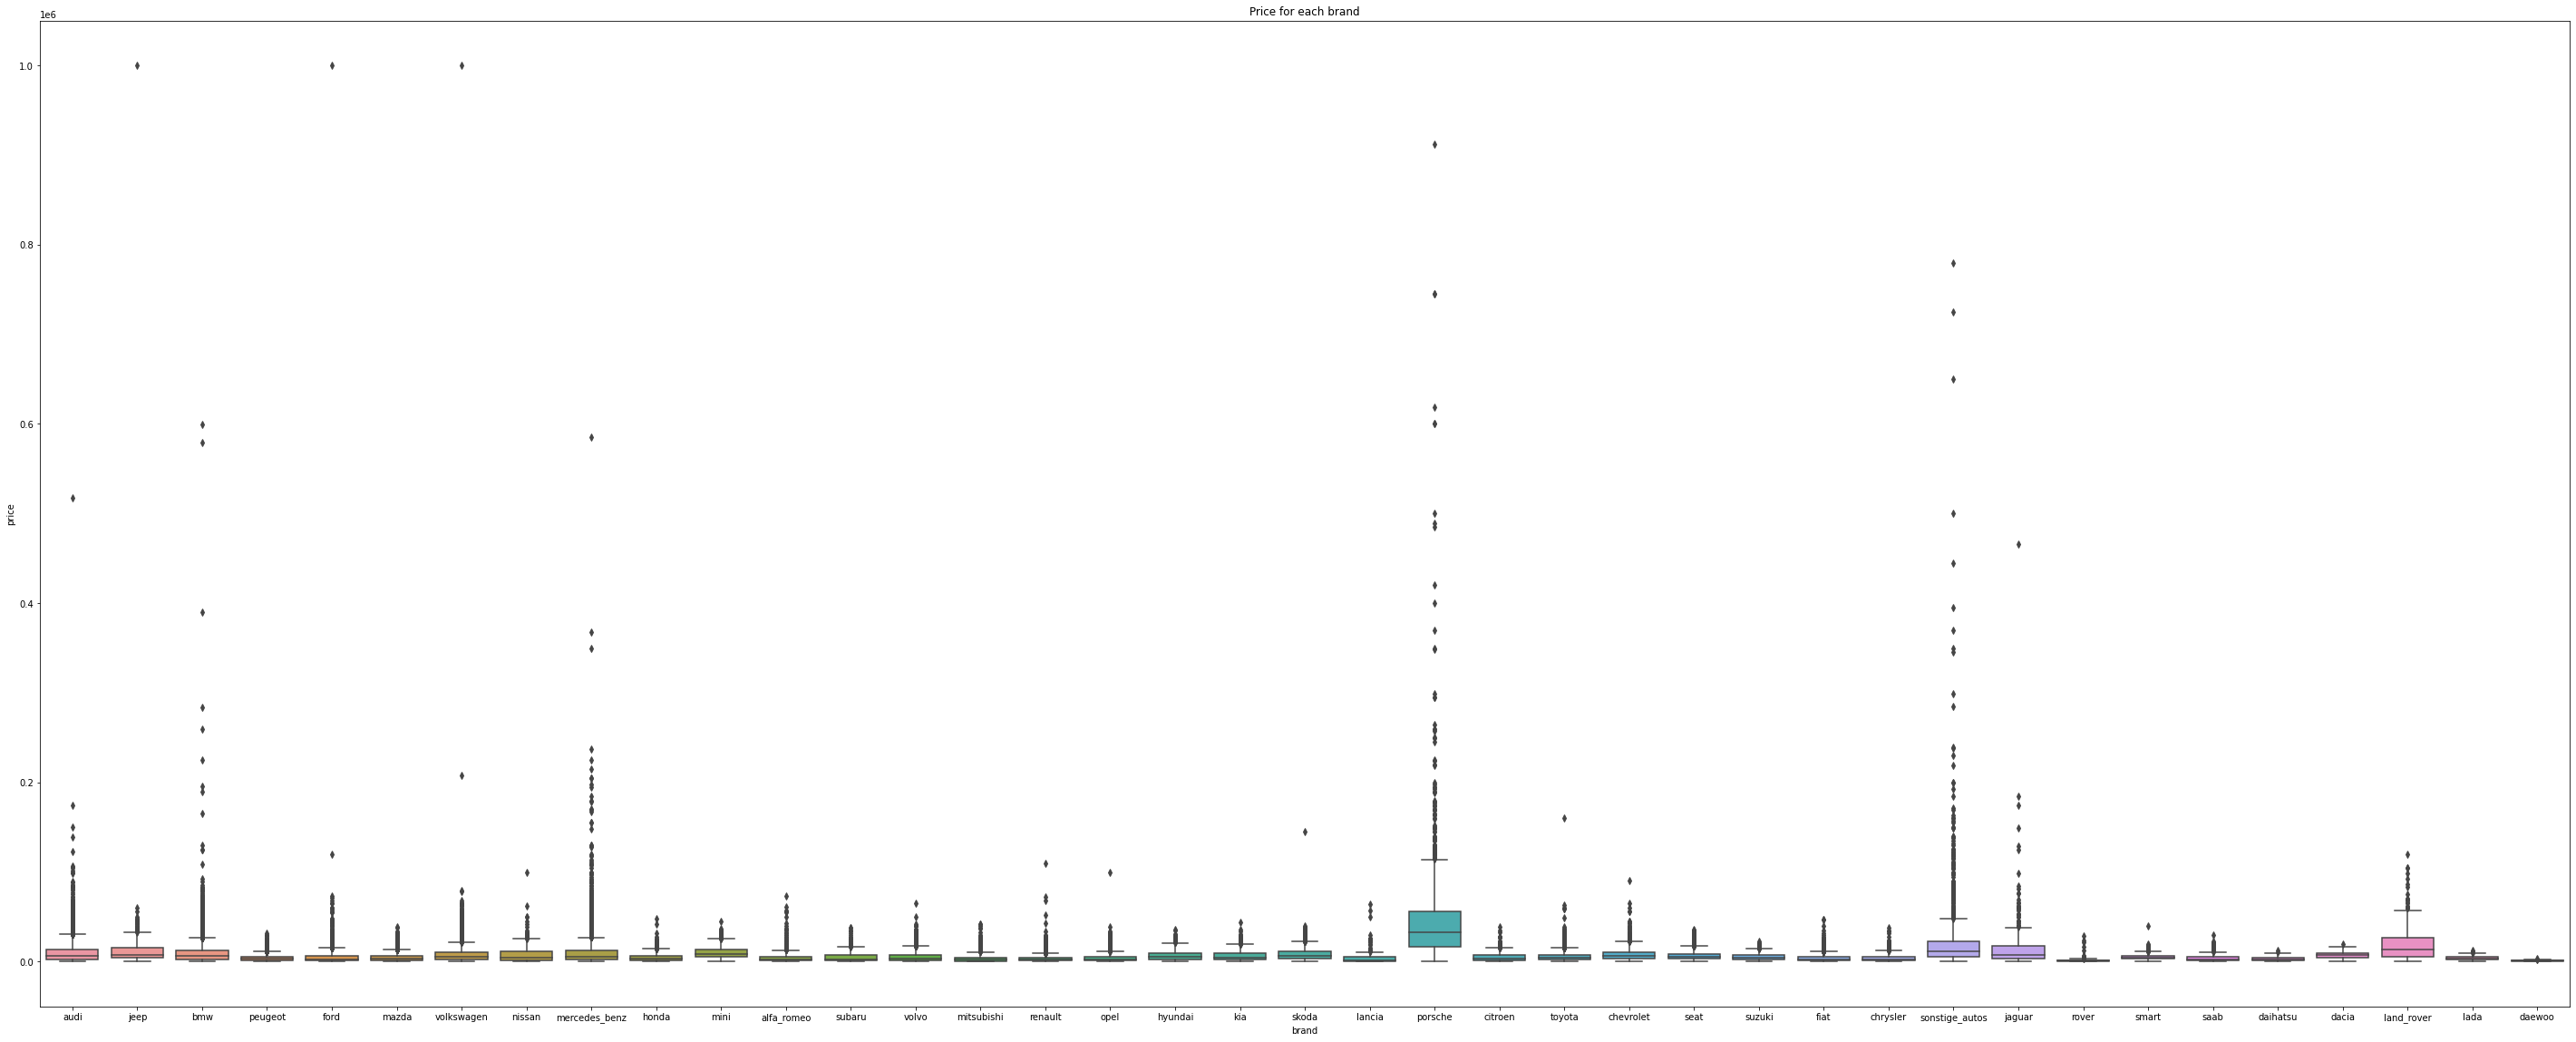

In [ ]:
plt.rcParams['figure.figsize']=(50,20)
sn.boxplot(x='brand', y="price", data=data).set_title('Price for each brand');

Como podemos ver, aun eliminando todos aquellos vehiculos con un precio superior a un 1M, seguimos teniendo muchos outliers, por lo que reduciremos todavía mas el precio máximo.

In [ ]:
data.where( (data.price < 100000), inplace = True)
data = data.dropna()

count    220361.000000
mean       7716.764350
std        8495.753687
min           1.000000
25%        2200.000000
50%        4999.000000
75%       10000.000000
max       99999.000000
Name: price, dtype: float64

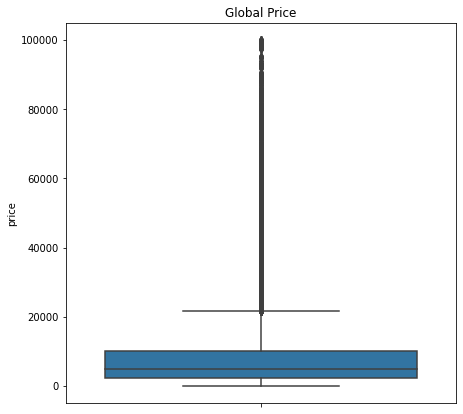

In [ ]:
plt.rcParams['figure.figsize']=(7,7)
sn.boxplot(y="price", data=data).set_title('Global Price');
data.price.describe()

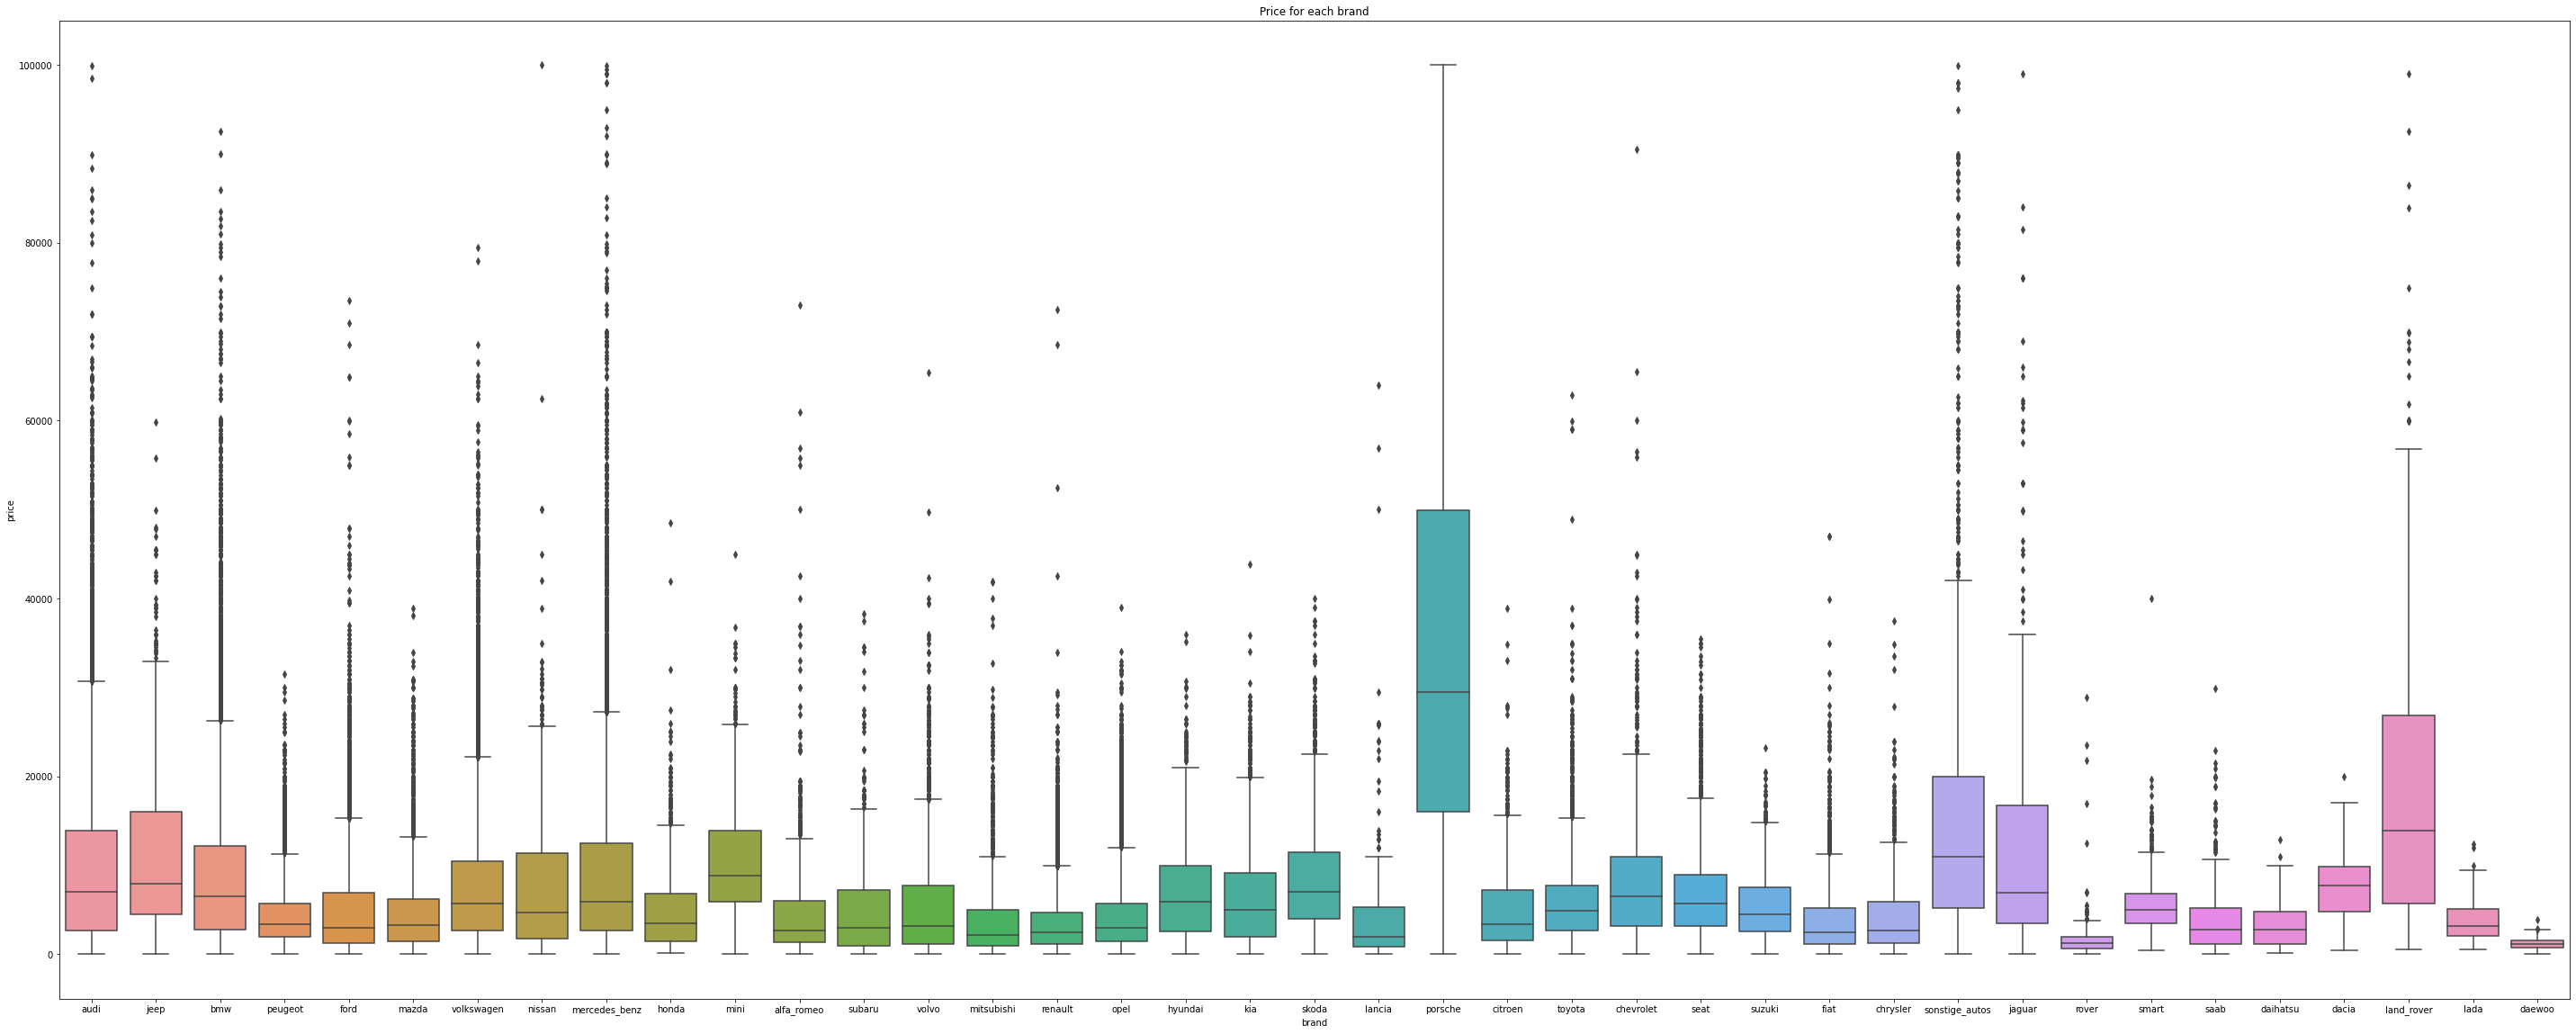

In [ ]:
plt.rcParams['figure.figsize']=(50,20)
sn.boxplot(x='brand', y="price", data=data).set_title('Price for each brand');

Con este sesgo vemos que no podemos reducir mas el abanico de valores ya que estariamos eliminando valores que no son outliers de ciertas marcas como Porsche.

In [ ]:
data.describe(include='all')

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,fuelType,brand,notRepairedDamage
count,220361.000000,220361,220361,220361.000000,220361,220361.000000,220361.000000,220361,220361,220361
unique,NaN,2,8,NaN,2,NaN,NaN,7,39,2
top,NaN,test,limousine,NaN,manuell,NaN,NaN,benzin,volkswagen,nein
freq,NaN,113982,74534,NaN,159196,NaN,NaN,127791,40340,202127
mean,7716.764350,NaN,NaN,2003.810856,NaN,147.334152,125400.955705,NaN,NaN,NaN
std,8495.753687,NaN,NaN,6.307695,NaN,58.234614,39492.802178,NaN,NaN,NaN
min,1.000000,NaN,NaN,1910.000000,NaN,80.000000,5000.000000,NaN,NaN,NaN
25%,2200.000000,NaN,NaN,2000.000000,NaN,105.000000,100000.000000,NaN,NaN,NaN
50%,4999.000000,NaN,NaN,2004.000000,NaN,136.000000,150000.000000,NaN,NaN,NaN
75%,10000.000000,NaN,NaN,2008.000000,NaN,170.000000,150000.000000,NaN,NaN,NaN


Una vez tratados los missings, los outliers, los valores incorrectos e innecesarios, pasamos a transformar las variables categóricas a numericas:

In [ ]:
data.abtest.replace(["control","test"],[0,1], inplace=True)
data.gearbox.replace(["manuell","automatik"],[0,1], inplace=True)
data.notRepairedDamage.replace(["nein","ja"],[0,1], inplace=True)


dummies = pd.get_dummies(data['vehicleType'], prefix='vehicleType')
data.drop(columns=['vehicleType'], inplace=True)
data = data.join(dummies)

dummies2 = pd.get_dummies(data['fuelType'], prefix='fuelType')
data.drop(columns=['fuelType'], inplace=True)
data = data.join(dummies2)

dummies3 = pd.get_dummies(data['brand'], prefix='brand')
data.drop(columns=['brand'], inplace=True)
data = data.join(dummies3)

data.describe()

,price,abtest,yearOfRegistration,gearbox,powerPS,kilometer,notRepairedDamage,vehicleType_andere,vehicleType_bus,vehicleType_cabrio,vehicleType_coupe,vehicleType_kleinwagen,vehicleType_kombi,vehicleType_limousine,vehicleType_suv,fuelType_andere,fuelType_benzin,fuelType_cng,fuelType_diesel,fuelType_elektro,fuelType_hybrid,fuelType_lpg,brand_alfa_romeo,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_volkswagen,brand_volvo
count,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.00000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000,220361.000000
mean,7716.764350,0.517251,2003.810856,0.277567,147.334152,125400.955705,0.082746,0.007070,0.109216,0.083077,0.070321,0.081398,0.252014,0.338236,0.058667,0.000200,0.579917,0.001724,0.398265,0.000109,0.000844,0.018942,0.008205,0.121714,0.150961,0.004992,0.004983,0.010592,0.002169,0.000844,0.000849,0.012244,0.061118,0.008373,0.009748,0.002351,0.002963,0.007692,0.000522,0.000948,0.002877,0.018197,0.127704,0.012843,0.008736,0.011490,0.085827,0.025122,0.008069,0.028744,0.001116,0.002006,0.014399,0.015506,0.00236,0.007401,0.002351,0.005732,0.012806,0.183063,0.012384
std,8495.753687,0.499703,6.307695,0.447800,58.234614,39492.802178,0.275499,0.083787,0.311911,0.276000,0.255688,0.273446,0.434170,0.473110,0.235002,0.014129,0.493573,0.041491,0.489542,0.010436,0.029041,0.136319,0.090208,0.326956,0.358012,0.070476,0.070413,0.102370,0.046524,0.029041,0.029119,0.109971,0.239547,0.091118,0.098248,0.048427,0.054356,0.087366,0.022839,0.030782,0.053561,0.133665,0.333761,0.112595,0.093056,0.106575,0.280110,0.156497,0.089462,0.167086,0.033393,0.044741,0.119129,0.123556,0.04852,0.085713,0.048427,0.075490,0.112438,0.386719,0.110593
min,1.000000,0.000000,1910.000000,0.000000,80.000000,5000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2200.000000,0.000000,2000.000000,0.000000,105.000000,100000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4999.000000,1.000000,2004.000000,

Una vez hecho esto, normalizaremos los datos:

Primero separaremos el target del resto de datos



In [ ]:
X = data.loc[:,data.columns != 'price']
y = data['price']

Para poder hacer la exploración con los métodos no lineales mas adelante, reduciremos el tamaño del dataset considerablemente (quedandonos con un 15% de él), debido al gran coste computacional y temporal que conllevan estos métodos con el número actual de datos.

Para ello usaremos la función de train_test_split para coger el 15% del dataset original con shuffle para evitar sesgos lo máximo posible.

In [ ]:
X_data_red, _, y_data_red, _ = train_test_split(X, y, test_size=0.85, random_state=42,shuffle=True)

Escalamos las columnas numericas no binarias con el StandardScaler y dividimos los datos en 80% Train y 20% Test mezclando las filas para eliminar posibles sesgos.

In [ ]:
def scaling(X, y, scaler=None):
    cols = [c for c in ['yearOfRegistration','powerPS','kilometer']]
    if scaler is None:
        scaler = StandardScaler()
        X[cols] = scaler.fit_transform(X[cols])
    else:
        X[cols] = scaler.transform(X[cols])
    return X, y, scaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data_red, y_data_red, test_size=0.2, random_state=42,shuffle=True)
X_train, y_train, scaler = scaling(X_train,y_train)
X_test, y_test, _ = scaling(X_test,y_test,scaler)

# Métodos lineales

In [ ]:
X_train.describe()

,abtest,yearOfRegistration,gearbox,powerPS,kilometer,notRepairedDamage,vehicleType_andere,vehicleType_bus,vehicleType_cabrio,vehicleType_coupe,vehicleType_kleinwagen,vehicleType_kombi,vehicleType_limousine,vehicleType_suv,fuelType_andere,fuelType_benzin,fuelType_cng,fuelType_diesel,fuelType_elektro,fuelType_hybrid,fuelType_lpg,brand_alfa_romeo,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_volkswagen,brand_volvo
count,26443.000000,2.644300e+04,26443.000000,2.644300e+04,2.644300e+04,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.00000,26443.000000,26443.000000,26443.00000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000,26443.000000
mean,0.517150,-9.598736e-15,0.277465,3.105501e-16,6.788176e-16,0.081799,0.007034,0.106380,0.082668,0.069016,0.081609,0.248345,0.345725,0.059222,0.000189,0.583557,0.001853,0.393601,0.000113,0.000983,0.019703,0.008093,0.120372,0.151685,0.005483,0.005294,0.009984,0.002307,0.000908,0.000719,0.011912,0.062209,0.008925,0.009643,0.002156,0.002988,0.007147,0.000529,0.000908,0.002950,0.017585,0.130091,0.012669,0.009757,0.011232,0.086488,0.025829,0.008320,0.028514,0.001324,0.00208,0.014371,0.014673,0.00208,0.006921,0.002382,0.006505,0.011723,0.181144,0.012102
std,0.499715,1.000019e+00,0.447756,1.000019e+00,1.000019e+00,0.274063,0.083575,0.308329,0.275386,0.253487,0.273774,0.432061,0.475613,0.236044,0.013750,0.492978,0.043008,0.488557,0.010651,0.031342,0.138979,0.089597,0.325402,0.358722,0.073849,0.072571,0.099421,0.047975,0.030114,0.026796,0.108494,0.241540,0.094051,0.097728,0.046379,0.054578,0.084242,0.023004,0.030114,0.054232,0.131440,0.336410,0.111842,0.098295,0.105385,0.281089,0.158628,0.090834,0.166440,0.036358,0.04556,0.119015,0.120243,0.04556,0.082903,0.048753,0.080390,0.107640,0.385145,0.109341
min,0.000000,-7.437375e+00,0.000000,-1.152177e+00,-3.059195e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-6.017827e-01,0.000000,-7.276042e-01,-6.483905e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,3.408631e-02,0.000000,-2.011336e-01,6.204541e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

## Linear Regression

In [ ]:
kf = KFold(n_splits=5)
cv_r2 = []
for train_index, test_index in kf.split(X_train):
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]

    lr = LinearRegression()
    lr.fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)
    cv_r2.append(fold_r2)
print('R2 score:',np.mean(cv_r2))

R2 score: 0.6827137385757931


## Ridge Regression

In [ ]:
alpha = [1e-10,1e-5,1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
ridge_cv =RidgeCV(alphas=alpha,cv=5)
ridge_cv.fit(X_train,y_train)

ridge_r2 =  np.mean(cross_val_score(ridge_cv, X_train,y_train))

print('Best alpha:', ridge_cv.alpha_, '\nR2 score:',ridge_r2)

Best alpha: 5.0 
R2 score: 0.6836523069005728


##Lasso Regression

In [ ]:
alpha = [1e-10,1e-5,1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
lasso_cv =LassoCV(alphas=alpha,cv=5, max_iter=5000, tol = 0.1)
lasso_cv.fit(X_train,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best alpha:', lasso_cv.alpha_, '\nR2 score:',lasso_r2)

Best alpha: 1.0 
R2 score: 0.6828892285378647


Utilizando estos 3 modelos lineales vemos que el score es prácticamente el mismo en todos ellos. Si tuvieramos que elegir uno de estos modelos, escogeríamos el Lasso Regressor porque da mejor puntuación que el linear (todo y que no sea muy notable) y el tiempo que tarda no es mucho mayor (1s).

Ahora veremos si algún modelo de regresión no lineal nos da un mejor rendimiento:


# Métodos no-lineales

## SVR

In [ ]:
svr = SVR(kernel='rbf')
grid_params_svr = {
    'C' : [1000,1500,2000,2500,3000]
}

gs = GridSearchCV(svr, grid_params_svr, cv=2)
gs_results = gs.fit(X_train, y_train)
model_svr = gs_results.best_estimator_
model_svr.fit(X_train, y_train)
score_svr = model_svr.score(X_train, y_train)
print('Best model:',model_svr)
print('Best score:',score_svr)

Best model: SVR(C=3000)
Best score: 0.8448919807874137


## Random forest

In [ ]:
rf = RandomForestRegressor()
grid_params_rf = {
 'max_depth': [40, 60, 80, 100],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100,200,300,400]
 }

gs = GridSearchCV(rf, grid_params_rf, cv=2)
gs_results = gs.fit(X_train, y_train)
model_rf = gs_results.best_estimator_
model_rf.fit(X_train, y_train)
score_rf = model_rf.score(X_train, y_train)
print('Best model:',model_rf)
print('Best score:',score_rf)

Best model: RandomForestRegressor(max_depth=80, min_samples_split=5, n_estimators=300)
Best score: 0.9621991532594237


Finalmente, como ambos modelos obtienen un mejor rendimiento que los lineales , escogeremos como modelo final uno de los no-lineales.

Además viendo la diferencia de scores entre ellos, está bastante claro que Random Forest es el mejor modelo que podemos usar para nuestro dataset.


# Modelo final escogido

Como hemos podido comprobar en los apartados anteriores, el modelo que presenta un mejor score es Random Forest Regressor, además de ser bastante rápido. Por tanto, ese será el modelo que escogeremos para la estimación de su error de generalización

In [ ]:
best_rf = RandomForestRegressor(max_depth=80, min_samples_split=5, n_estimators=300)
best_rf.fit(X_train, y_train)
score_best_rf = best_rf.score(X_test, y_test)
print('Score:', score_best_rf)

Score: 0.8463409752658146


El error de generalización es bastante alto (cerca de 0.12), aunque el score obtenido prediciendo con los datos de Test sigue siendo mejor que el obtenido en el training con el resto de modelos.

Como conclusión, podemos decir que nuestro modelo padece un ligero overfiting pero aún así es el mejor modelo de los vistos durante el proyecto.

# Analisis de interpretabilidad

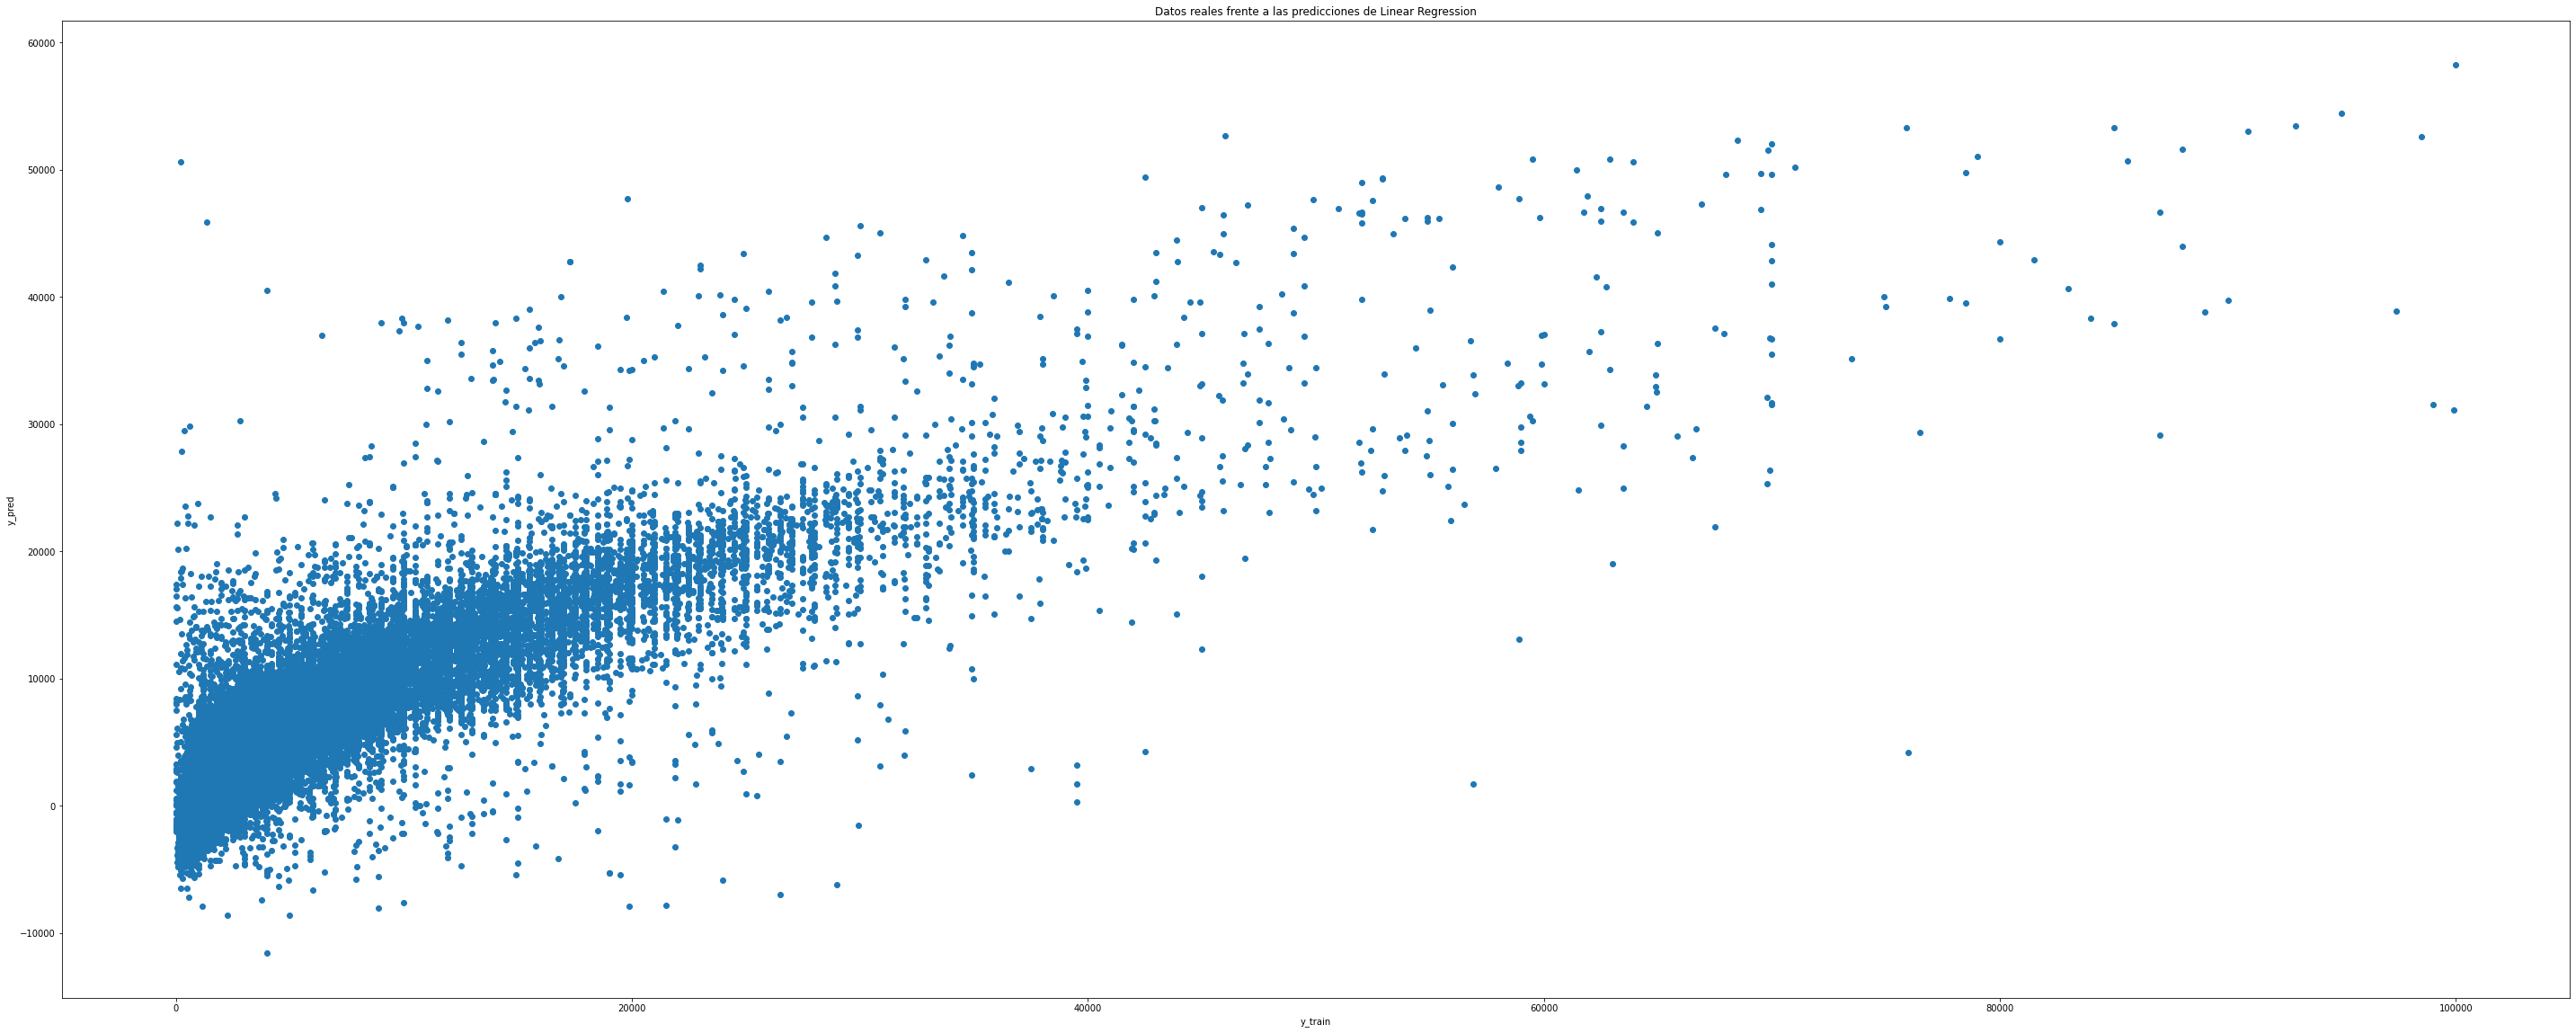

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_train)

plt.scatter(y_train,y_pred)
plt.title('Datos reales frente a las predicciones de Linear Regression')
plt.xlabel('y_train')
plt.ylabel('y_pred')
plt.show()

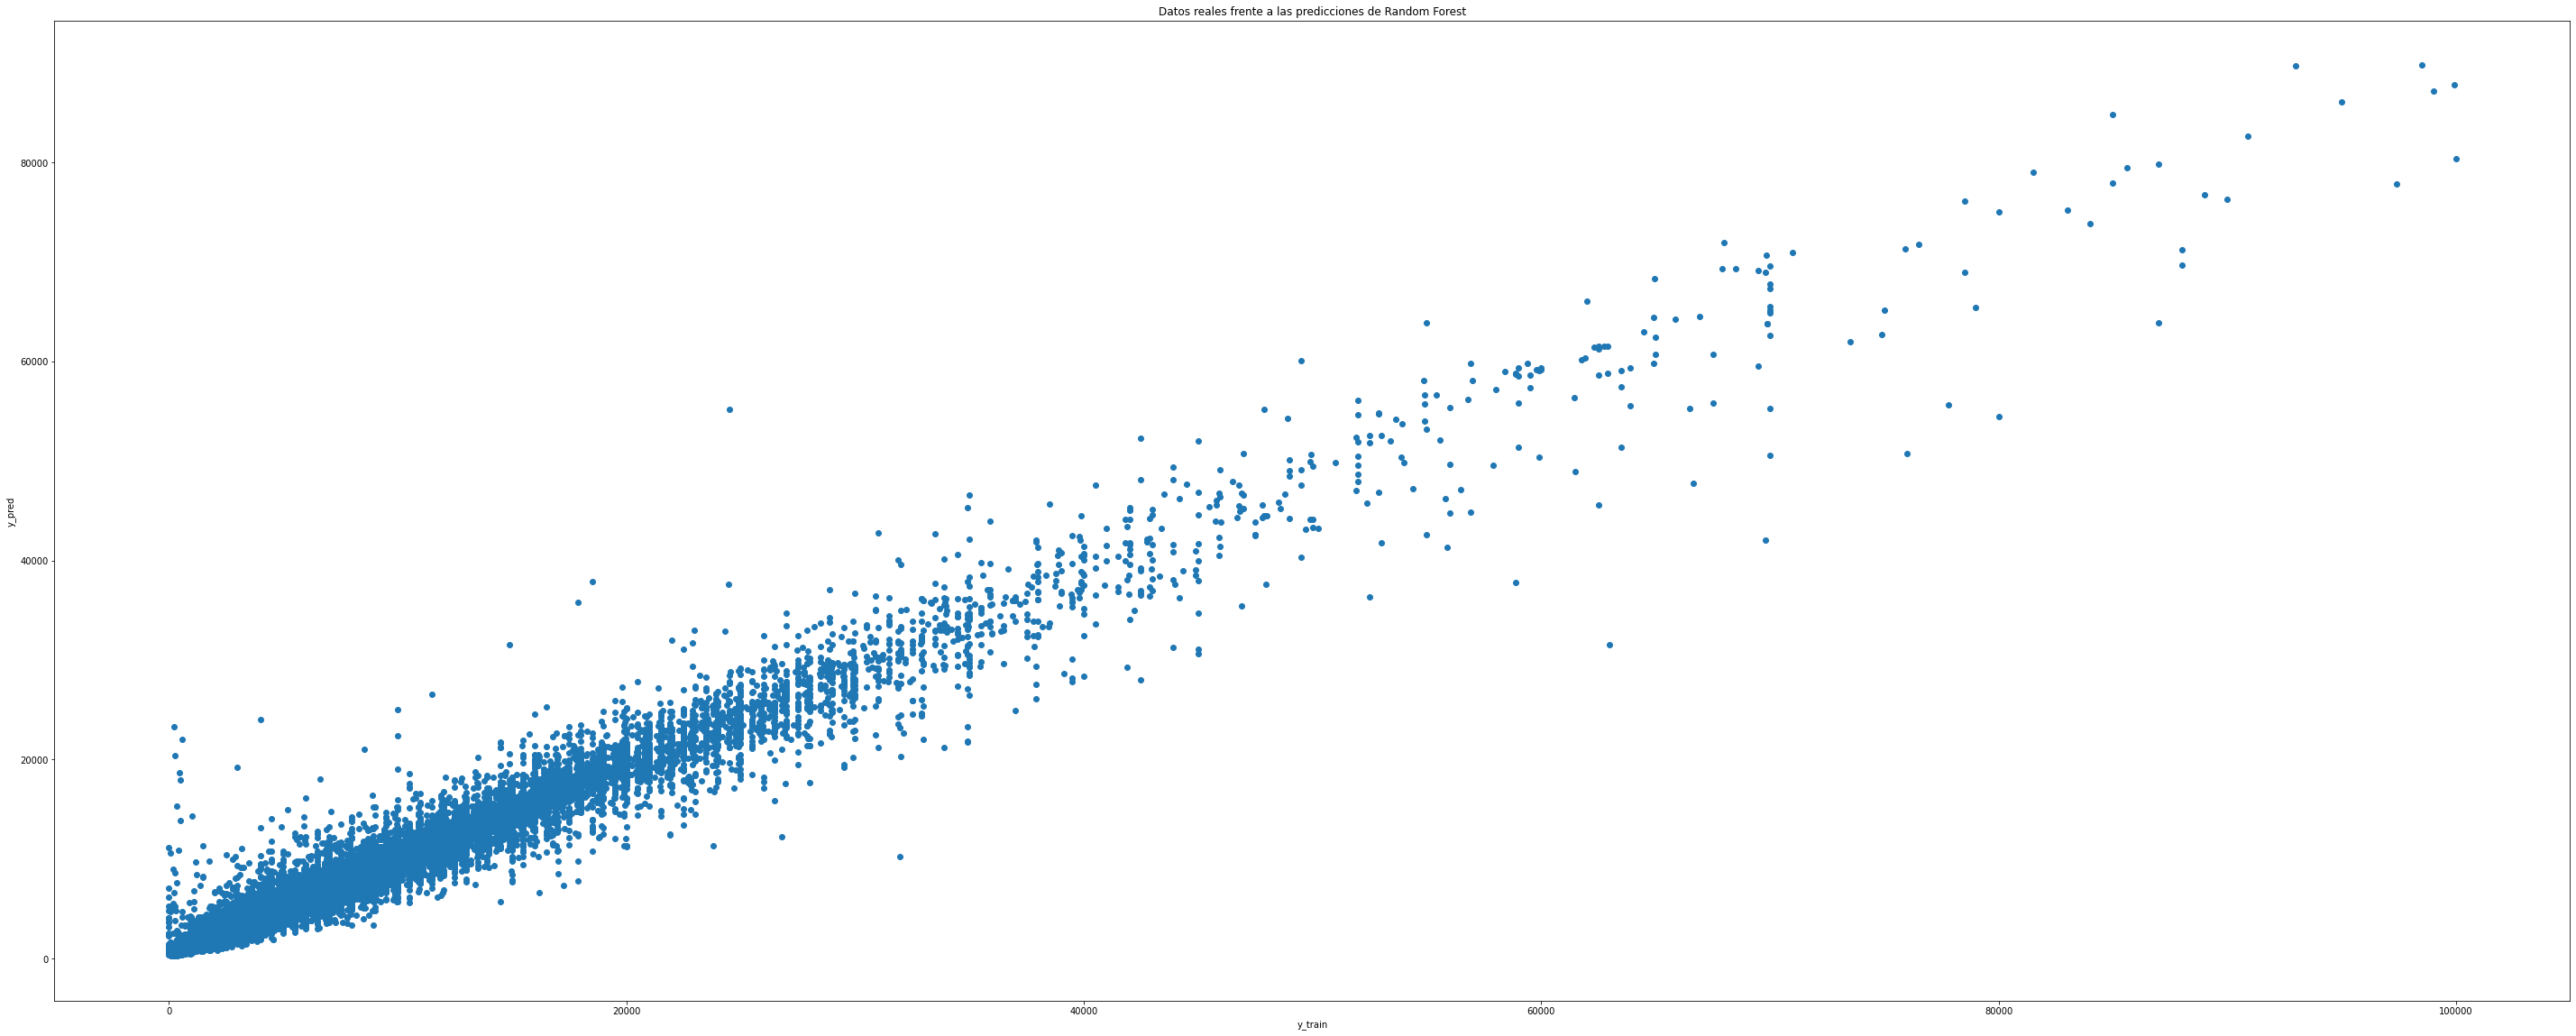

In [ ]:
best_rf = RandomForestRegressor(max_depth=80, min_samples_split=5, n_estimators=300)
best_rf.fit(X_train, y_train)
rf_pred = best_rf.predict(X_train)

plt.scatter(y_train,rf_pred)
plt.title('Datos reales frente a las predicciones de Random Forest')
plt.xlabel('y_train')
plt.ylabel('y_pred')
plt.show()